# Implementation of Adaptive Image Watermarking Based on DWT and DWT-DCT Transformations for Visual Copyright Protection

Anggota Kelompok :

1.   Muhammad Fahmi Syihab (23031554218)
2.   Widya Louisa (23031554180)
3.   Royan Firdaus (23031554223)

Kelas : 2023 A

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import pywt

In [ ]:
citra_host = Image.open('Dataset steganografi dan watermarking (Kim Se-jeong).jpg')
citra_watermark = Image.open('Citra Label Watermark.png')

In [ ]:
# menampilkan citra
# Convert PIL Image to OpenCV format for cv2_imshow
citra_host = cv2.cvtColor(np.array(citra_host), cv2.COLOR_RGB2BGR)
citra_watermark = cv2.cvtColor(np.array(citra_watermark), cv2.COLOR_RGB2BGR)

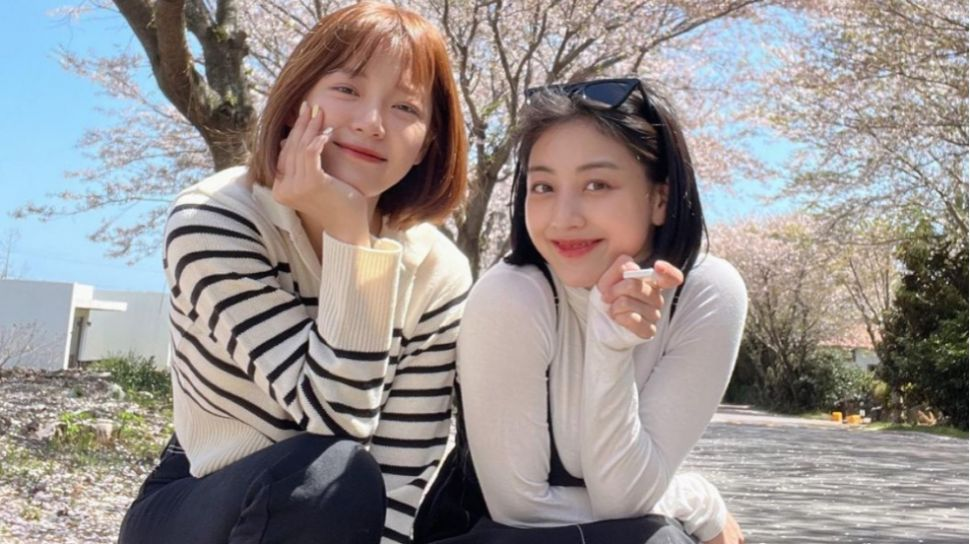

In [ ]:
# citra host
cv2_imshow(citra_host)

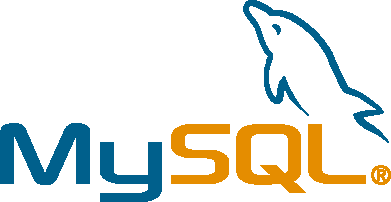

In [ ]:
#citra watermark
cv2_imshow(citra_watermark)

##EDA

---



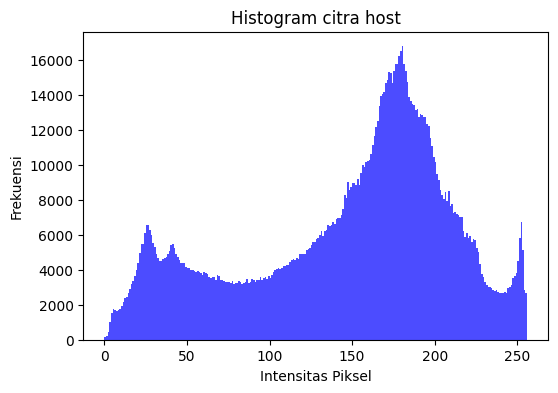

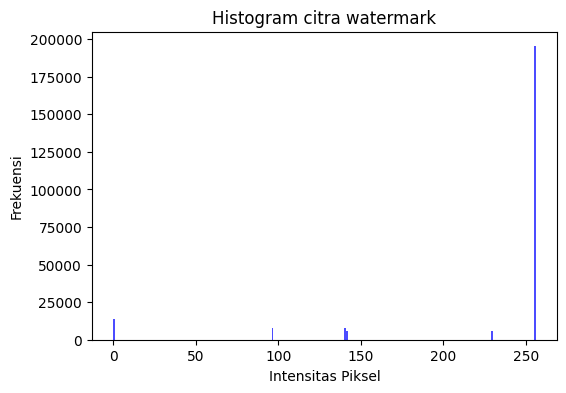

In [ ]:
# Fungsi menampilkan histogram
import matplotlib.pyplot as plt
def plot_histogram(image, title):
    plt.figure(figsize=(6, 4))
    plt.hist(image.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel('Intensitas Piksel')
    plt.ylabel('Frekuensi')
    plt.show()

# Menampilkan histogram
plot_histogram(citra_host, "Histogram citra host")
plot_histogram(citra_watermark, "Histogram citra watermark")

In [ ]:
print(f'Ukuran citra host: {citra_host.shape}')
print(f'Ukuran citra watermark: {citra_watermark.shape}')

Ukuran citra host: (544, 970, 3)
Ukuran citra watermark: (202, 391, 3)


## PRE - PROCESSING

---



1. GRAY SCALE

In [ ]:
host_image = cv2.imread('Dataset steganografi dan watermarking (Kim Se-jeong).jpg', cv2.IMREAD_GRAYSCALE)
watermark = cv2.imread('Citra Label Watermark.png', cv2.IMREAD_GRAYSCALE)

array([[192, 192, 192, ..., 168, 159, 247],
       [192, 192, 192, ..., 178, 165, 248],
       [192, 192, 192, ..., 199, 183, 255],
       ...,
       [197, 197, 193, ..., 114, 111, 254],
       [211, 219, 224, ..., 106, 110, 255],
       [216, 228, 241, ..., 111, 108, 255]], dtype=uint8)
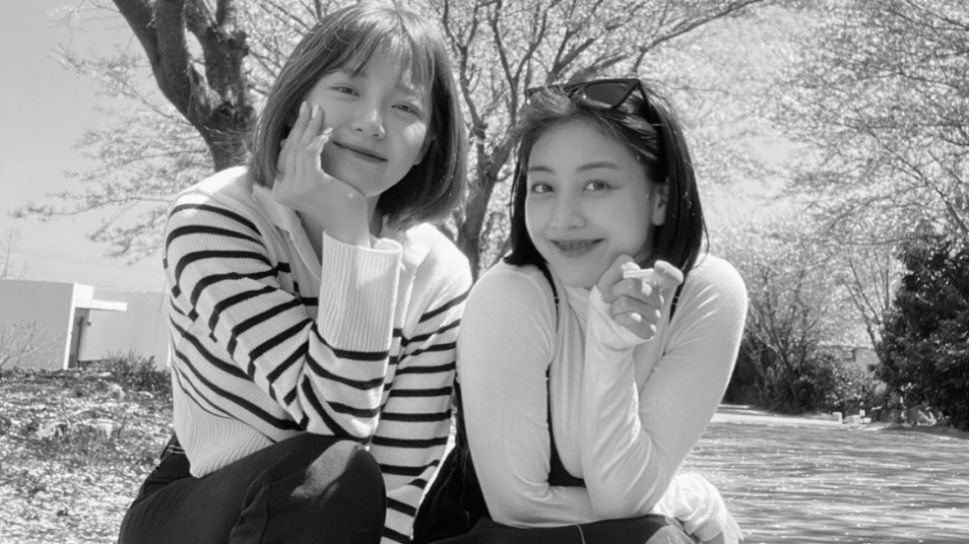

In [ ]:
host_image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
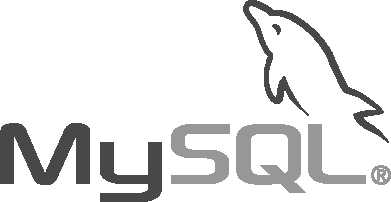

In [ ]:
watermark

2. RESIZE WATERMARK

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
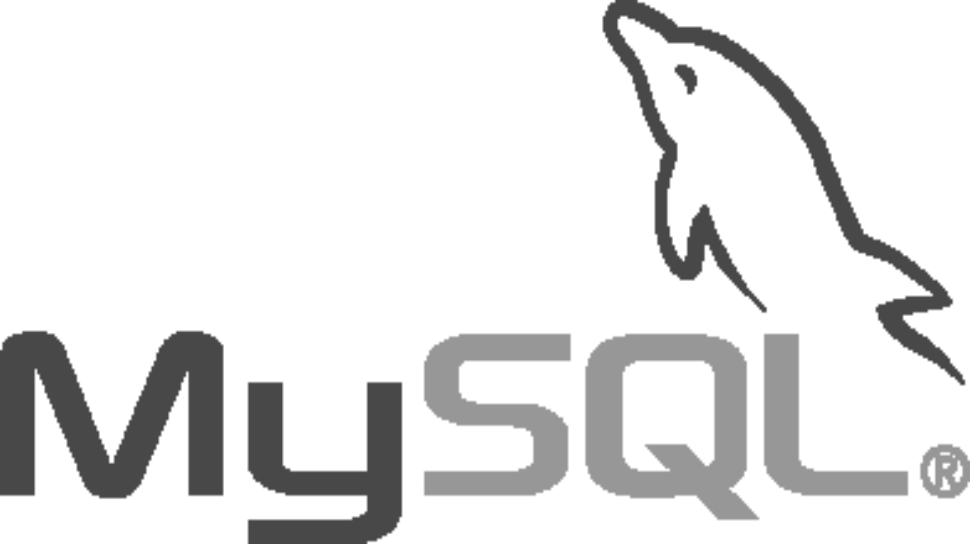

In [ ]:
watermark1 = cv2.resize(watermark, (host_image.shape[1], host_image.shape[0]))
watermark1

##WATERMARK EMBEDDING

---



1. DCT ONLY

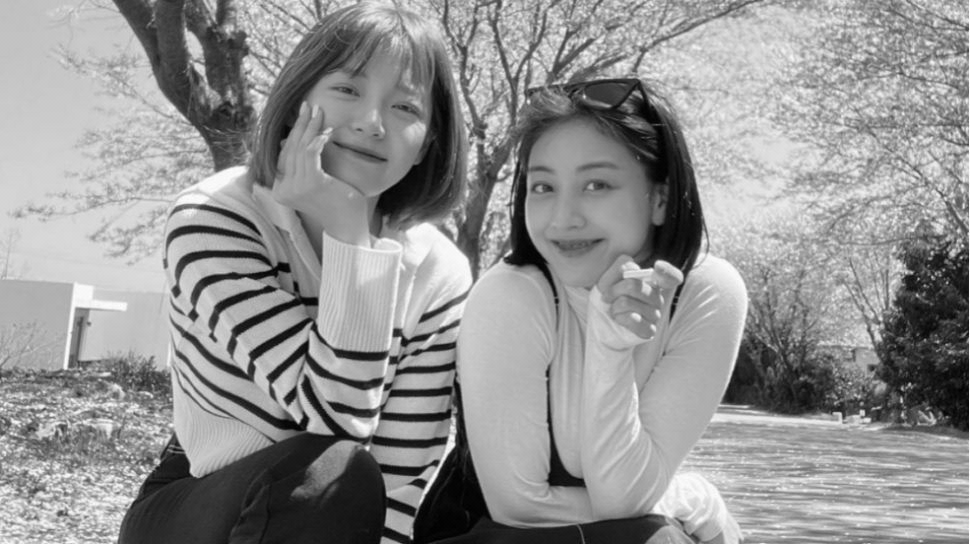

In [ ]:
import cv2
import numpy as np

# Ukuran blok DCT
block_size = 8

# Resize watermark agar jumlah bloknya sesuai dengan jumlah blok di host
wm_h = host_image.shape[0] // block_size
wm_w = host_image.shape[1] // block_size
watermark_resized = cv2.resize(watermark, (wm_w, wm_h))

# Konversi watermark menjadi biner (0 atau 1)
_, watermark_binary = cv2.threshold(watermark_resized, 127, 1, cv2.THRESH_BINARY)

# Salin host image sebagai array float untuk modifikasi
watermarked_image_dct = host_image.copy().astype(np.float32)

# Parameter ambang adaptif (threshold)
alpha = 1  # Semakin besar, semakin kuat penyisipan

# Proses penyisipan watermark
u = 0  # Indeks watermark
for i in range(0, host_image.shape[0], block_size):
    for j in range(0, host_image.shape[1], block_size):
        # Hindari blok yang tidak pas 8x8
        if i + block_size > host_image.shape[0] or j + block_size > host_image.shape[1]:
            continue

        block_P = host_image[i:i+block_size, j:j+block_size].astype(np.float32)
        dct_P = cv2.dct(block_P)

        # Posisi koefisien yang digunakan
        m, n = 4, 4
        if m >= dct_P.shape[0] or n >= dct_P.shape[1]:
            continue

        # Nilai watermark pada posisi blok ini
        wm_bit = watermark_binary[i//block_size, j//block_size]

        p_val = dct_P[m, n]
        threshold = alpha

        # Penyisipan berdasarkan algoritma
        if wm_bit == 0 and p_val < threshold:
            dct_P[m, n] += threshold
            u += 1
        elif wm_bit == 1 and p_val > -threshold:
            dct_P[m, n] -= threshold
            u += 1
        # else: tidak disisipkan (biarkan nilai aslinya)

        # Invers DCT dan simpan ke citra hasil
        idct_block = cv2.idct(dct_P)
        watermarked_image_dct[i:i+block_size, j:j+block_size] = idct_block

# Pastikan dalam rentang 0–255 dan konversi ke uint8
watermarked_image_dct = np.clip(watermarked_image_dct, 0, 255).astype(np.uint8)

# Simpan dan tampilkan hasil
cv2_imshow(watermarked_image_dct)
cv2.waitKey(0)
cv2.destroyAllWindows()



In [ ]:
cv2.imwrite('watermarked_dct.png', watermarked_image_dct)

True

### 2. DWT-DCT

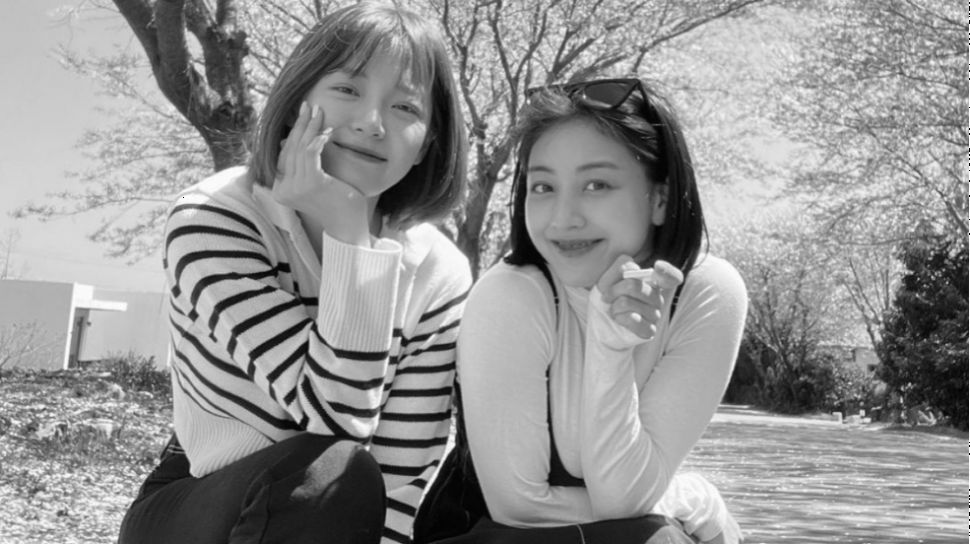

In [ ]:

def embed_watermark_dwct(host_image, watermark, alpha=0.05,):
    # Apply 3-level DWT on watermark
    coeffs = pywt.wavedec2(watermark, 'haar',level=3)

    # bagi host image menjadi 8x8 block
    blocks = [host_image[i:i+8, j:j+8]
              for i in range(0, host_image.shape[0], 8)
              for j in range(0, host_image.shape[1],8)]

    # hitung threshold sebagai pecahan rata rata datndar deviasi  dari coeffs
    avg_std = np.mean([np.std(pywt.wavedec2(block, 'haar', level=3)[0]) for block in blocks])
    alpha =0.05

    # apply dct disetiap block
    dct_blocks = [cv2.dct(np.float32(block))for block in blocks]
    vr = alpha * 0.001

    #embed watermark kedalam dct coeffs menggunakan nilai threshold
    num_blocks_per_row = host_image.shape[1] // 8

    for i in range(len(blocks)):
        block = dct_blocks[i]
        row = i // num_blocks_per_row
        col = i % num_blocks_per_row
        threshold = (alpha * vr) * avg_std

        if abs(block[0, 0]) > threshold:
            if row < coeffs[0].shape[0] and col < coeffs[0].shape[1]:
                watermark_block = coeffs[0][row][col]
                block[0, 0] = (1 + (alpha * vr) * watermark_block) * block[0, 0]
                dct_blocks[i] = block


    # invers dct untuk mendapatkan watermark image
    watermarked_image_dwtdct = np.zeros_like(host_image)
    k = 0
    for i in range(0, host_image.shape[0], 8):
      for j in range(0, host_image.shape[1], 8):
        block = cv2.idct(dct_blocks[k])
        watermarked_image_dwtdct[i:i+8, j:j+8] = block
        k +=1

    cv2_imshow(watermarked_image_dwtdct)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imwrite('watermarked_image_dwtdct.png', watermarked_image_dwtdct)

    return watermarked_image_dwtdct, coeffs

watermarked_image_dwct, coeffs_dwct = embed_watermark_dwct(host_image, watermark1)

## EVALUASI CITRA

---

In [ ]:
# from skimage.metrics import peak_signal_noise_ratio as psnr --> error
from skimage.metrics import structural_similarity as ssim

def psnr(img1, img2):
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

In [ ]:
# watermarked_image_dwt = cv2.resize(watermarked_dwt, (host_image.shape[1], host_image.shape[0]))
watermarked_image_dwt_dct = watermarked_image_dwct

CROPPING

In [ ]:
psnr_dct = psnr(host_image, watermarked_image_dct)
ssim_dct = ssim(host_image, watermarked_image_dct, data_range=watermarked_image_dct.max() - watermarked_image_dct.min())

psnr_dwt_dct = psnr(host_image, watermarked_image_dwt_dct)
ssim_dwt_dct = ssim(host_image, watermarked_image_dwt_dct, data_range=watermarked_image_dwt_dct.max() - watermarked_image_dwt_dct.min())

print("📊 Evaluasi Kualitas:")
print(f"DCT Only     → PSNR: {psnr_dct:.2f} dB, SSIM: {ssim_dct:.4f}")
print(f"DWT-DCT      → PSNR: {psnr_dwt_dct:.2f} dB, SSIM: {ssim_dwt_dct:.4f}")

📊 Evaluasi Kualitas:
DCT Only     → PSNR: 51.17 dB, SSIM: 0.9986
DWT-DCT      → PSNR: 38.29 dB, SSIM: 0.9995


##SIMULASI ATTACK

---



In [ ]:
wm_dct = cv2.imread('watermarked_dct.png', cv2.IMREAD_GRAYSCALE)
wm_dwt_dct = cv2.imread('watermarked_image_dwtdct.png', cv2.IMREAD_GRAYSCALE)
# wm_dwt_dct = cv2.imread('watermarked_adaptive.png', cv2.IMREAD_GRAYSCALE)

In [ ]:
from skimage.util import random_noise

class SeranganWatermark:
    @staticmethod
    def salt_and_pepper(img, amount=0.02):
        noisy = random_noise(img, mode='s&p', amount=amount)
        return (noisy * 255).astype(np.uint8)

    @staticmethod
    def gaussian_noise(img, var=0.01):
        noisy = random_noise(img, mode='gaussian', var=var)
        return (noisy * 255).astype(np.uint8)

    @staticmethod
    def jpeg_compression(img, quality=25):
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        _, encimg = cv2.imencode('.jpg', img, encode_param)
        decimg = cv2.imdecode(encimg, 0)
        return decimg

    @staticmethod
    def attack(img):
      sp = SeranganWatermark.salt_and_pepper(img)
      gauss = SeranganWatermark.gaussian_noise(img)
      jpeg = SeranganWatermark.jpeg_compression(img)
      return sp, gauss, jpeg


1. DCT ONLY

In [ ]:
# Simulasi Serangan
salt_dct, gauss_dct, jpeg_dct = SeranganWatermark.attack(wm_dct)

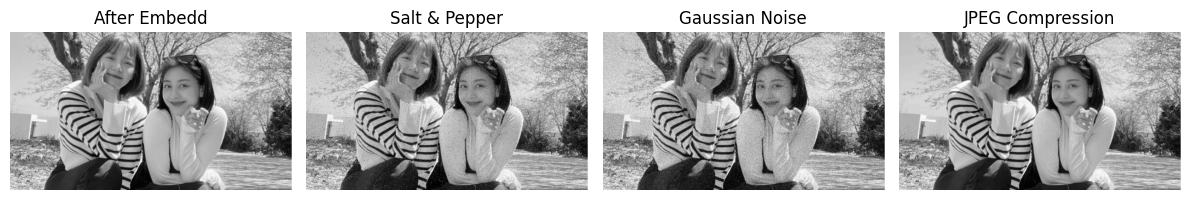

In [ ]:
titles = ["After Embedd", "Salt & Pepper", "Gaussian Noise", "JPEG Compression"]
images = [wm_dct, salt_dct, gauss_dct, jpeg_dct]

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

2. DWT-DCT

In [ ]:
salt_dwtdct, gauss_dwtdct, jpeg_dwtdct = SeranganWatermark.attack(wm_dwt_dct)

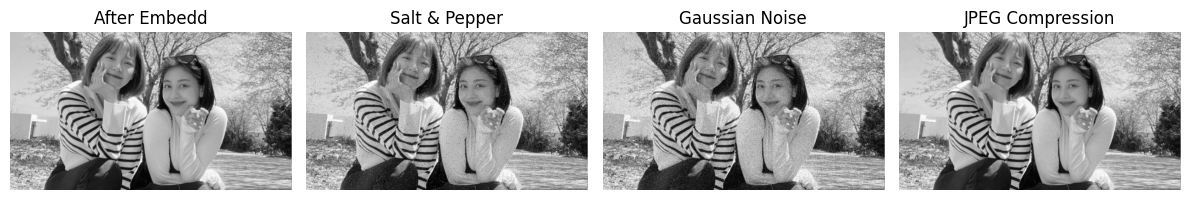

In [ ]:
titles = ["After Embedd","Salt & Pepper", "Gaussian Noise", "JPEG Compression"]
images = [wm_dwt_dct, salt_dwtdct, gauss_dwtdct, jpeg_dwtdct]

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis("off")
plt.tight_layout()
plt.show()


##WATERMARK EXTRACTION (BLIND  EXTRACTION )

---



1. DCT Only

In [ ]:

def extract_watermark_dct(attacked_img, host_img, alpha=10):
    block_size = 8

    # Salin ukuran watermark
    wm_h = host_image.shape[0] // block_size
    wm_w = host_image.shape[1] // block_size
    watermark_bits = []

    # Proses ekstraksi dari citra dct
    for i in range(0, host_image.shape[0], block_size):
        for j in range(0, host_image.shape[1], block_size):
            if i + block_size > host_image.shape[0] or j + block_size > host_image.shape[1]:
                continue

            # Blok DCT dari host dan watermarked image
            block_P = host_image[i:i+block_size, j:j+block_size].astype(np.float32)
            block_Q = attacked_img[i:i+block_size, j:j+block_size].astype(np.float32)

            dct_P = cv2.dct(block_P)
            dct_Q = cv2.dct(block_Q)

            m, n = 4, 4
            if m >= dct_P.shape[0] or n >= dct_P.shape[1]:
                continue

            p_val = dct_P[m, n]
            q_val = dct_Q[m, n]

            # Ekstraksi berdasarkan pembandingan nilai DCT
            if q_val < p_val:  # Dulu dikurangi (wm_bit = 1)
                watermark_bits.append(1)
            else:  # Tidak dikurangi atau ditambah (wm_bit = 0)
                watermark_bits.append(0)

    # Ubah list bit ke array dan bentuk ukuran watermark
    watermark_array = np.array(watermark_bits[:wm_h * wm_w])
    wm_dct = watermark_array.reshape((wm_h, wm_w)).astype(np.uint8) * 255

    return wm_dct


wm_dct_battack = extract_watermark_dct(wm_dct, host_image)
wm_salt_dct = extract_watermark_dct(salt_dct, host_image)
wm_gauss_dct = extract_watermark_dct(gauss_dct, host_image)
wm_jpeg_dct = extract_watermark_dct(jpeg_dct, host_image)


In [ ]:
def normalized_correlation(wm1, wm2):
    # Ensure both inputs are float and scaled
    wm1 = wm1.astype(np.float32) / 255
    wm2 = wm2.astype(np.float32) / 255

    # Check if dimensions match
    if wm1.shape != wm2.shape:
        wm2_resized = cv2.resize(wm2, (wm1.shape[1], wm1.shape[0]), interpolation=cv2.INTER_NEAREST)
        wm2 = wm2_resized

    # Calculate NC
    num = np.sum(wm1 * wm2)
    den = np.sqrt(np.sum(wm1 ** 2) * np.sum(wm2 ** 2))
    return num / den if den != 0 else 0 # Avoid division by zero

NC Watermark Before Attack: 0.9801
NC Watermark Salt & Pepper: 0.8006
NC Watermark Gaussian Noise: 0.7274
NC Watermark JPEG Compression: 0.6155


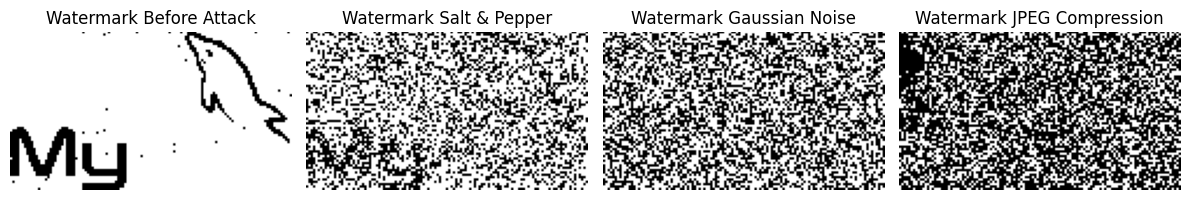

In [ ]:
titles = ["Watermark Before Attack","Watermark Salt & Pepper", "Watermark Gaussian Noise", "Watermark JPEG Compression"]
images = [wm_dct_battack, wm_salt_dct, wm_gauss_dct, wm_jpeg_dct]

plt.figure(figsize=(12, 6))
for i in range(4):
    nc = normalized_correlation(watermark, images[i])
    print(f"NC {titles[i]}: {nc:.4f}")

    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis("off")
plt.tight_layout()
plt.show()


2. DWT-DCT

NC (JPEG Attack): 0.4099


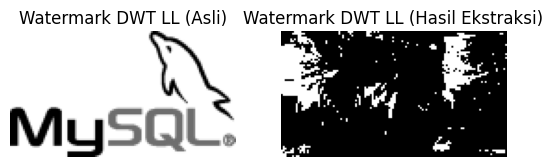

In [ ]:
import pywt
import numpy as np
import cv2

def extract_watermark_dwt_dct(attacked_img, host_img, wm_shape, alpha=0.05):
    # 1. Dekomposisi citra host & attacked menjadi blok 8x8
    blocks_attacked = [attacked_img[i:i+8, j:j+8] for i in range(0, attacked_img.shape[0], 8)
                                                      for j in range(0, attacked_img.shape[1], 8)]
    blocks_host = [host_img[i:i+8, j:j+8] for i in range(0, host_img.shape[0], 8)
                                              for j in range(0, host_img.shape[1], 8)]

    # 2. Hitung DCT masing-masing blok
    dct_attacked = [cv2.dct(np.float32(b)) for b in blocks_attacked]
    dct_host = [cv2.dct(np.float32(b)) for b in blocks_host]

    # 3. Bandingkan DC coefficient [0,0] untuk dapatkan bit watermark
    extracted_bits = []
    for ba, bh in zip(dct_attacked, dct_host):
        bit = 1 if ba[0, 0] > bh[0, 0] else 0
        extracted_bits.append(bit)

    # 4. Rekonstruksi watermark berdasarkan shape LL watermark
    max_len = wm_shape[0] * wm_shape[1]
    wm_array = np.array(extracted_bits[:max_len])
    watermark_extracted = wm_array.reshape(wm_shape)
    return watermark_extracted

def normalized_correlation(original, extracted):
    original = original.astype(np.float32)
    extracted = extracted.astype(np.float32)
    num = np.sum(original * extracted)
    den = np.sqrt(np.sum(original**2) * np.sum(extracted**2))
    return num / den if den != 0 else 0

# Ambil shape dari watermark DWT level-3 LL-nya
coeffs_wm = pywt.wavedec2(watermark1, 'haar', level=3)
LL_wm = coeffs_wm[0]
wm_shape = LL_wm.shape

#  Ekstraksi dari hasil attack (misalnya JPEG)
extracted_jpeg = extract_watermark_dwt_dct(wm_dwt_dct, host_image, wm_shape)
nc_jpeg = normalized_correlation(LL_wm, extracted_jpeg)
print(f"NC (JPEG Attack): {nc_jpeg:.4f}")

# Tampilkan hasil
plt.subplot(1, 2, 1)
plt.imshow(LL_wm, cmap='gray')
plt.title("Watermark DWT LL (Asli)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(extracted_jpeg, cmap='gray')
plt.title("Watermark DWT LL (Hasil Ekstraksi)")
plt.axis("off")

plt.show()


EVALUASI SESUDAH SIMULASI ATTACK

---



In [ ]:
def evaluasi(ori, diserang, label):
    p = psnr(ori, diserang)
    s = ssim(ori, diserang)
    print(f"{label} \t -> PSNR = {p:.2f} dB, SSIM = {s:.4f}")

In [ ]:
evaluasi(host_image, gauss_dwtdct, "Gaussian Noise dwct")
evaluasi(host_image, salt_dwtdct, "Salt & Pepper dwct")
evaluasi(host_image, jpeg_dwtdct, "JPEG Compression dwct")
print('-----------------------------------------')
evaluasi(host_image, gauss_dct, "Gaussian Noise dct")
evaluasi(host_image, salt_dct, "Salt & Pepper dct")
evaluasi(host_image, jpeg_dct, "JPEG Compression dct")

Gaussian Noise dwct 	 -> PSNR = 20.17 dB, SSIM = 0.4119
Salt & Pepper dwct 	 -> PSNR = 21.97 dB, SSIM = 0.6820
JPEG Compression dwct 	 -> PSNR = 32.61 dB, SSIM = 0.9380
-----------------------------------------
Gaussian Noise dct 	 -> PSNR = 20.22 dB, SSIM = 0.4125
Salt & Pepper dct 	 -> PSNR = 22.07 dB, SSIM = 0.6816
JPEG Compression dct 	 -> PSNR = 33.69 dB, SSIM = 0.9384
